In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# To simulate stock prices, we need some input parameters.
# setup params for brownian motion
s0 = 131.00
sigma = 0.25
mu = 0.35

# setup the simulation
paths = 1000
delta = 1.0/252.0
time = 252 * 5

# Start by defining the initial stock price, s0. 
# Then sigma which is the percentage volatility. 
# Finally, mu (drift), which determine the overall trend.

# Setup the simulation with 1,000 simulation paths. 
# delta refers to the time step. 
# I want to model a new stock price every day so I use 1/252 to represent 1 day
# in 252 trading days. The length of the simulation is 5 years.

In [4]:
def wiener_process(delta, sigma, time, paths):
    """Returns a Wiener process
    
    Parameters
    ----------
    delta : float
        The increment to downsample sigma
    sigma : float
        Percentage volatility
    time : int
        Number of samples to create
    paths : int
        Number of price simulations to create
    
    Returns
    -------
    wiener_process : np.ndarray
    
    Notes
    -----
    This method returns a Wiener process. 
    The Wiener process is also called Brownian 
    motion. For more information about the 
    Wiener process check out the Wikipedia 
    page: http://en.wikipedia.org/wiki/Wiener_process
    """

    # return an array of samples from a normal distribution
    return sigma * np.random.normal(loc=0, scale=np.sqrt(delta), size=(time, paths))

In [5]:
def gbm_returns(delta, sigma, time, mu, paths):
    """Returns from a Geometric brownian motion
    
    Parameters
    ----------
    delta : float
        The increment to downsample sigma
    sigma : float
        Percentage volatility
    time : int
        Number of samples to create
    mu : float
        Percentage drift
    paths : int
        Number of price simulations to create
    
    Returns
    -------
    gbm_returns : np.ndarray
    
    Notes
    -----
    This method constructs random Geometric Brownian 
    Motion (GBM).
    """
    process = wiener_process(delta, sigma, time, paths)
    return np.exp(
        process + (mu - sigma**2 / 2) * delta
    )

In [6]:
def gbm_levels(s0, delta, sigma, time, mu, paths):
    """Returns price paths starting at s0
    
    Parameters
    ----------
    s0 : float
        The starting stock price
    delta : float
        The increment to downsample sigma
    sigma : float
        Percentage volatility
    time : int
        Number of samples to create
    mu : float
        Percentage drift
    paths : int
        Number of price simulations to create
    
    Returns
    -------
    gbm_levels : np.ndarray
    """
    returns = gbm_returns(delta, sigma, time, mu, paths)

    stacked = np.vstack([np.ones(paths), returns])
    return s0 * stacked.cumprod(axis=0)

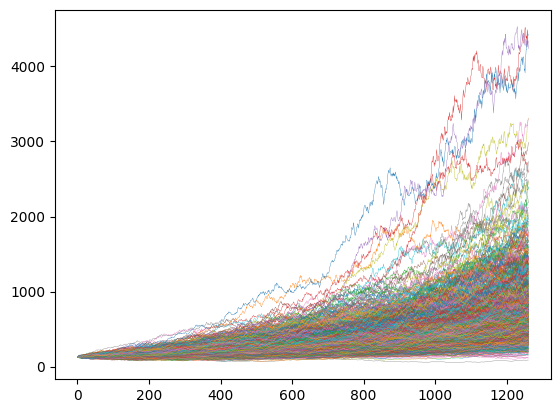

In [7]:
price_paths = gbm_levels(s0, delta, sigma, time, mu, paths)
plt.plot(price_paths, linewidth=0.25)
plt.show()

In [8]:
# As you might expect, a 35% drift causes most price paths to increase 
# from from the initial price. 
# In fact we can test exactly how many have increased from the initial price.

len(price_paths[-1, price_paths[-1, :] > s0])

996

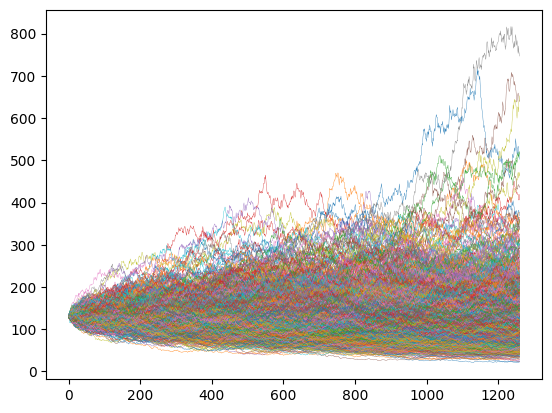

In [9]:
# In the second example I set the drift to 0.0.

price_paths = gbm_levels(s0, delta, sigma, time, 0.0, paths)
plt.plot(price_paths, linewidth=0.25)
plt.show()